In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from flow.calibrate import compute_lag, calib_video, exclude_outliers
from tqdm import tqdm
from flow.calibrate import VideoData
from datetime import datetime

%load_ext autoreload
%autoreload 2

In [2]:
zaber_path = './data/2023-10-04T10_19_11_b12_all_params_file.csv'
video_path = './data/231004_101805_video.avi'
t0 = 10
length = 30

lag, vindex, zindex, corr = compute_lag(zaber_path, video_path, t0, length)
print('Lag:%.3f (ms)' % (lag * 1000))
print('%d, %d, %.3f' % (vindex, zindex, corr))

Lag:-5266.667 (ms)
1203, 143, 0.533


### Varibility

In [3]:
np.random.seed(0)
t0 = np.sort(np.random.randint(0, 120, size=10))
length = np.arange(10, 65, 10)

all_lag = np.zeros((len(t0), len(length)))
for i in tqdm(range(len(t0))):
    for j in range(len(length)):
        all_lag[i, j] = compute_lag(zaber_path, video_path, t0[i], length[j])

100%|██████████| 10/10 [09:51<00:00, 59.19s/it]


-3.263 +/- 3.142
-5.257 +/- 0.015
-5.250 +/- 0.017
-5.260 +/- 0.013
-5.267 +/- 0.000
-5.267 +/- 0.000


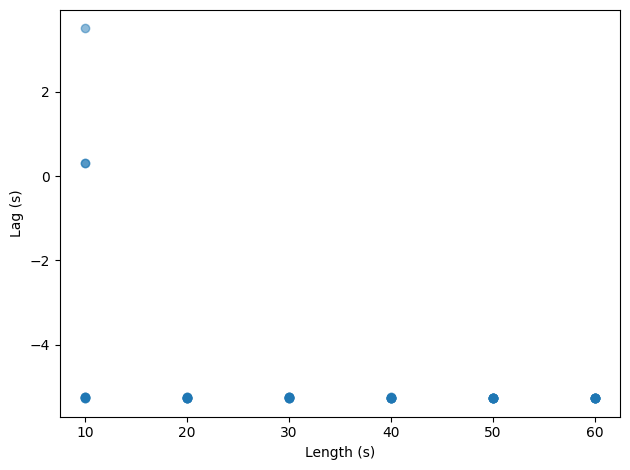

In [10]:
plt.figure()
for i in range(len(length)):
    estimate = ('%.3f +/- %.3f' % (np.mean(all_lag[:, i]),
                                   np.std(all_lag[:, i])))
    print(estimate)
    for j in range(len(t0)):
        plt.scatter(length[i], all_lag[j, i],
                    c='tab:blue', alpha=0.5)

plt.xlabel('Length (s)')
plt.ylabel('Lag (s)')
plt.tight_layout()
plt.show()

### Lag throughout a video

In [24]:
t0 = np.linspace(0, 3500, 60)

In [26]:
window_length = 30
all_lag = np.zeros_like(t0, dtype=float)

for i in tqdm(range(len(t0))):
    all_lag[i] = compute_lag(zaber_path, video_path, t0[i], window_length)

100%|██████████| 60/60 [09:19<00:00,  9.33s/it]


In [28]:
# exclude outliers
lag_mean = np.mean(all_lag)
lag_sd = np.std(all_lag)
indice = np.abs(all_lag - lag_mean) < 3 * lag_sd

t0 = t0[indice]
all_lag = all_lag[indice]

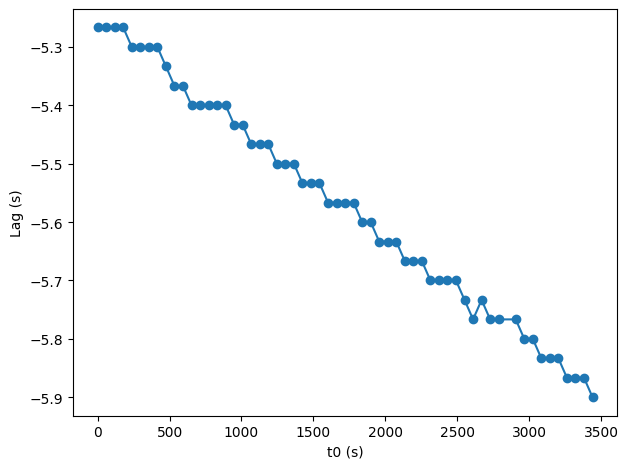

In [29]:
fig = plt.figure()
plt.plot(t0, all_lag, 'o-')
plt.xlabel('t0 (s)')
plt.ylabel('Lag (s)')
plt.tight_layout()
plt.show()

In [2]:
# Test on different video
zaber_path = './data/2024-03-13T10_43_09_p16_all_params_file.csv'
video_path = './data/20240313_104327_hs.mp4'
t0 = 10
length = 60

lag = compute_lag(zaber_path, video_path, t0, length)
print('Lag:%.3f (ms)' % (lag * 1000))

Lag:-5300.000 (ms)


In [3]:
t0 = np.linspace(0, 3500, 60)

window_length = 30
all_lag = np.zeros_like(t0, dtype=float)

for i in tqdm(range(len(t0))):
    all_lag[i] = compute_lag(zaber_path, video_path, t0[i], window_length)

100%|██████████| 60/60 [09:54<00:00,  9.91s/it]


In [5]:
# exclude outliers
# with s.d.
lag_mean = np.mean(all_lag)
lag_sd = np.std(all_lag)
indice = np.abs(all_lag - lag_mean) < 3 * lag_sd

t0 = t0[indice]
all_lag = all_lag[indice]

In [12]:
# with derivative
threshold = 0.25
dlag = np.abs(np.diff(all_lag))
indice = np.where(dlag > threshold)[0] + 1
t0_prime = np.delete(t0, indice)
lag_prime = np.delete(all_lag, indice)

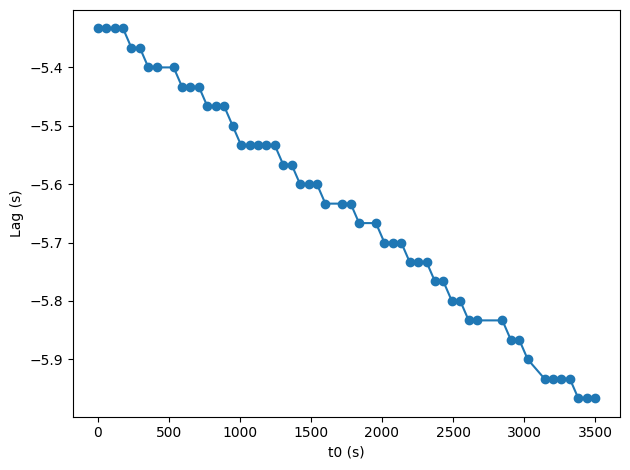

In [13]:
fig = plt.figure()
plt.plot(t0_prime, lag_prime, 'o-')
plt.xlabel('t0 (s)')
plt.ylabel('Lag (s)')
plt.tight_layout()
plt.show()

In [2]:
zaber_path = './data/2024-11-22T08_55_17_b17_all_params_file.csv'
video_path = './data/20241122_085538_hs.mp4'
t0, lag = calib_video(zaber_path, video_path, exclude=False)

100%|██████████| 60/60 [09:17<00:00,  9.29s/it]


4 Point are Excluded (outside 3 s.d.)
4 Point are Excluded (large derivative)


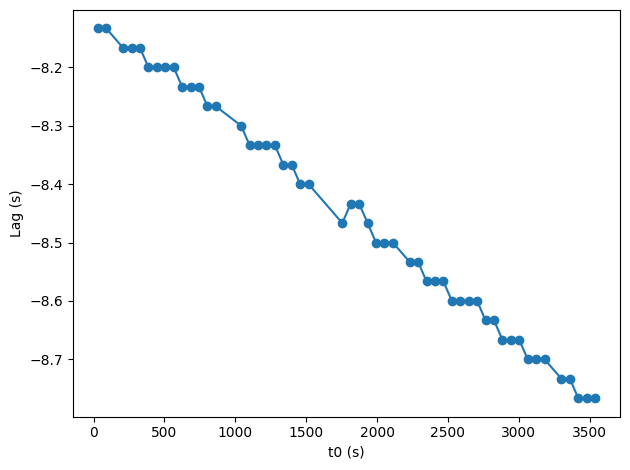

In [4]:
fig = plt.figure()

t0, lag = exclude_outliers(t0, lag)
plt.plot(t0, lag, 'o-')
plt.xlabel('t0 (s)')
plt.ylabel('Lag (s)')
plt.tight_layout()
plt.show()

### Validation

In [ ]:
zaber_path = './data/2024-10-15T11_47_32_b18_all_params_file.csv'
video_path = './data/20241015_113759_hs.mp4'
t0, lag = calib_video(zaber_path, video_path,
                      n_point=30, window=60,
                      exclude=False)

  0%|          | 0/30 [00:00<?, ?it/s]

0 Point are Excluded (outside 3 s.d.)
0 Point are Excluded (large derivative)


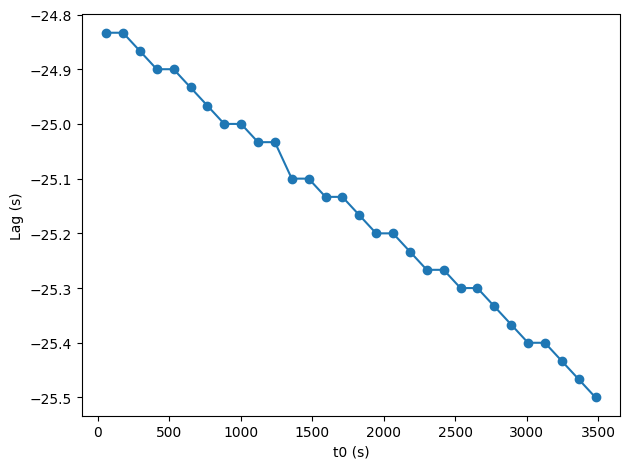

In [10]:
fig = plt.figure()

t0, lag = exclude_outliers(t0, lag)
plt.plot(t0, lag, 'o-')
plt.xlabel('t0 (s)')
plt.ylabel('Lag (s)')
plt.tight_layout()
plt.show()

In [4]:
# video time
video = VideoData(video_path, step=1)
n_frames = video.video.get(cv2.CAP_PROP_FRAME_COUNT)
t_frame = np.arange(n_frames) / video.fr
print('total frames:', int(n_frames))

# read in time stamp
calib_path = './data/hs_cam_frames_2024-10-15T11_47_35.csv'
df = pd.read_csv(calib_path)
is_frame = df.iloc[:, 0].to_numpy()

time_stamp = df.iloc[:, 1].to_numpy()
time_stamp = [t[11:26] for t in time_stamp]
time_objects = [datetime.strptime(ts, '%H:%M:%S.%f') for ts in time_stamp]
initial_time = time_objects[0]
relative_time = [(t - initial_time).total_seconds() for t in time_objects]

relative_time = np.array(relative_time)[is_frame]
print('total frames:', len(relative_time))

total frames: 431951
total frames: 52496


### Check affine transformation alignment

Alignemnt CVS File  
Report index + time lag

In [2]:
# test calibration on entire video
zaber_path = './data/2024-10-15T11_47_32_b18_all_params_file.csv'
video_path = './data/20241015_113759_hs.mp4'
t0, calibration = calib_video(zaber_path, video_path, exclude=True)

100%|██████████| 60/60 [19:57<00:00, 19.96s/it]

8 Point(s) Excluded (correlation < 0.30)


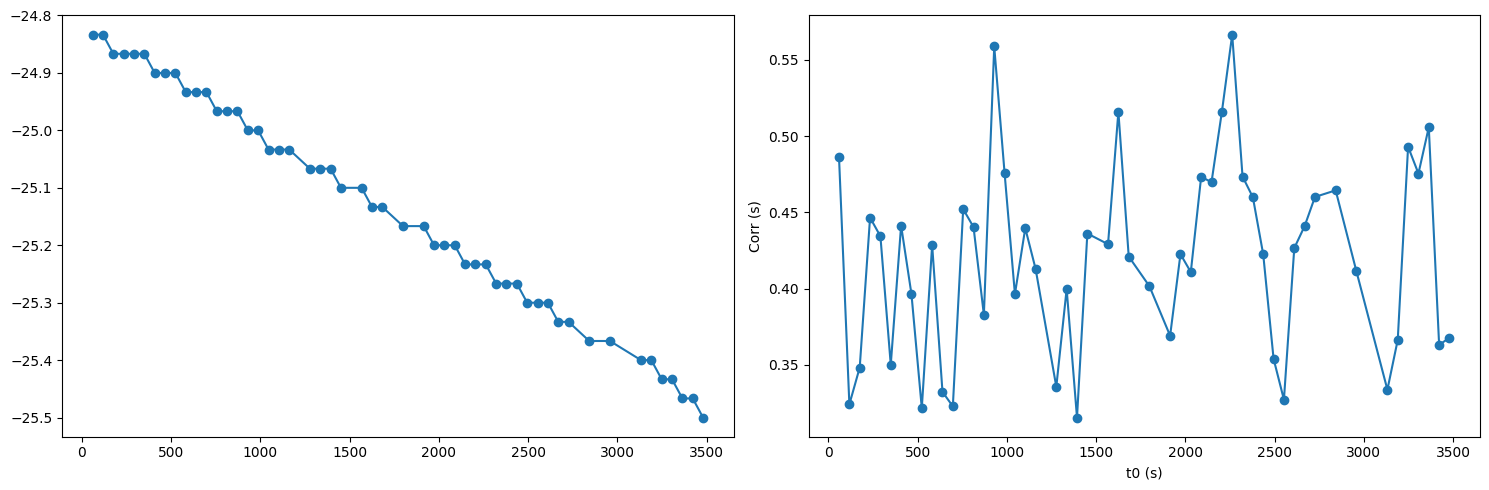

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# lag
axs[0].plot(t0, calibration[0], 'o-')
plt.xlabel('t0 (s)')
plt.ylabel('Lag (s)')

# correlation r value
axs[1].plot(t0, calibration[3], 'o-')
plt.xlabel('t0 (s)')
plt.ylabel('Corr (s)')

plt.tight_layout()
plt.show()

In [10]:
# corresponding video and zaber index
v_index = calibration[1]
z_index = calibration[2]

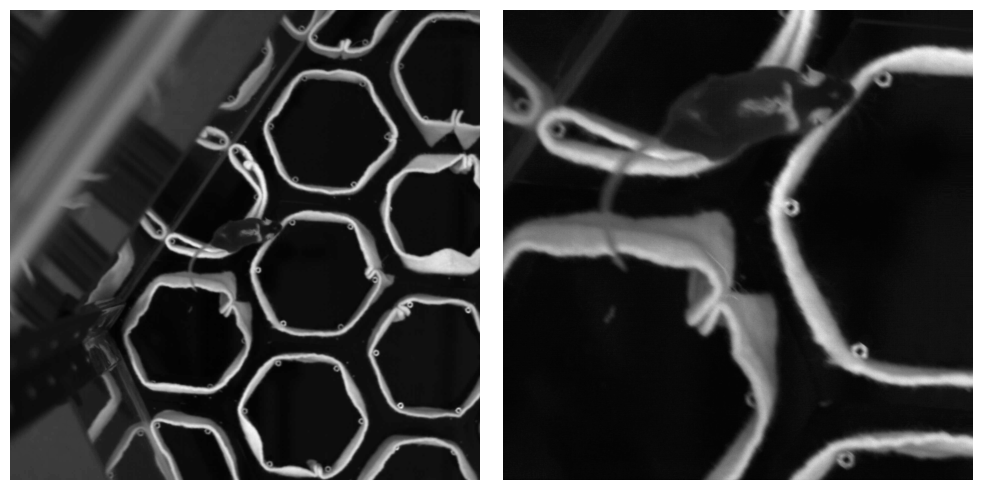

In [55]:
# check frame alignment
low_res = cv2.VideoCapture('./data/video_basler_2024-10-15T11_47_32.avi')
high_res = cv2.VideoCapture('./data/20241015_113759_hs.mp4')

anchor = 50
low_res.set(cv2.CAP_PROP_POS_FRAMES, z_index[anchor])
high_res.set(cv2.CAP_PROP_POS_FRAMES, v_index[anchor])

# read frame
low_frame = cv2.cvtColor(low_res.read()[1], cv2.COLOR_BGR2GRAY)
high_frame = cv2.cvtColor(high_res.read()[1], cv2.COLOR_BGR2GRAY)

equalize = False
if equalize:
    low_frame = cv2.equalizeHist(low_frame)
    high_frame = cv2.equalizeHist(high_frame)

# show corresponding frames
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(low_frame, cmap='gray')

# flip x and y axis
axs[1].imshow(high_frame, cmap='gray')
axs[0].invert_xaxis()
axs[1].invert_yaxis()

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Save format

In [62]:
# write to csv file
header = ['lag', 'video_index', 'zaber_index', 'correlation']
output_path = './calib.csv'

df = pd.DataFrame({h: calibration[i] for i, h in enumerate(header)})
df.to_csv(output_path, index=False)
